In [13]:
from bitarray import bitarray
import random
import numpy as np
import math

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [16]:
import pandas as pd
import os

In [17]:
file = pd.read_csv("heart.csv")
file.head()
file.values

array([[63.,  1.,  3., ...,  0.,  1.,  1.],
       [37.,  1.,  2., ...,  0.,  2.,  1.],
       [41.,  0.,  1., ...,  0.,  2.,  1.],
       ...,
       [68.,  1.,  0., ...,  2.,  3.,  0.],
       [57.,  1.,  0., ...,  1.,  3.,  0.],
       [57.,  0.,  1., ...,  1.,  2.,  0.]])

In [18]:
x_train = np.array(file.values[:,:-1])
y_train = np.array(file.values[:,-1]).reshape(-1,1).astype(int)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(sum(y_train))

(303, 13)
(303, 1)
[165]


In [20]:
x_train = StandardScaler().fit_transform(x_train)

In [21]:
fpr_values = []
size_values = []

# Kraska Hash Model

In [22]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,nums):
    pred = bf.predict(x_train)
    tn, fp, fn, tp = confusion_matrix(y_train, pred).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [27]:
def get_data_points_Kraska(x_train,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model.save('model_test.h5')
        model_size = os.stat('model_test.h5').st_size

        m = model_size//100
        net_size = 1.01*model_size/1024

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_train)

        print("Size: %f - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values += [fpr]
        size_values += [net_size]

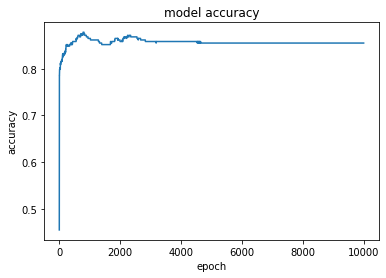

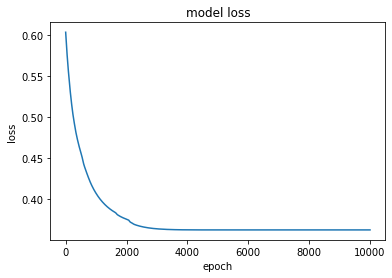

Size: 25.186875 - FPR: 0.152174 





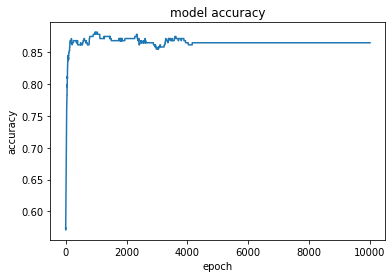

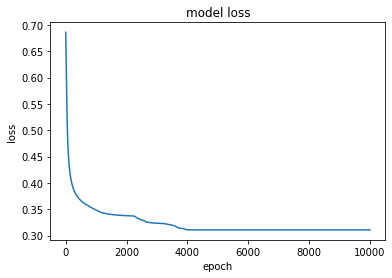

Size: 33.661406 - FPR: 0.536232 





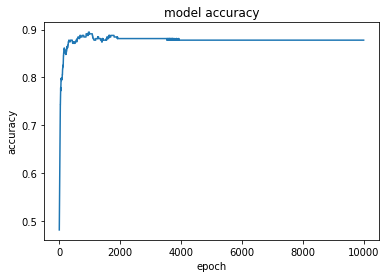

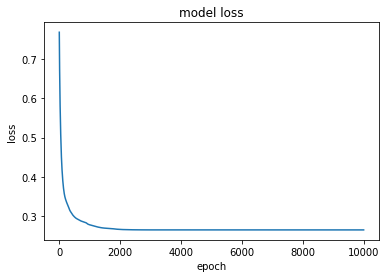

Size: 42.041250 - FPR: 0.079710 





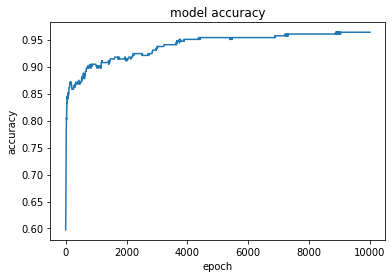

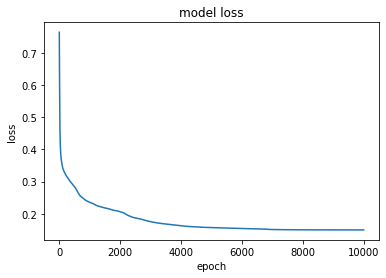

Size: 50.744609 - FPR: 0.057971 





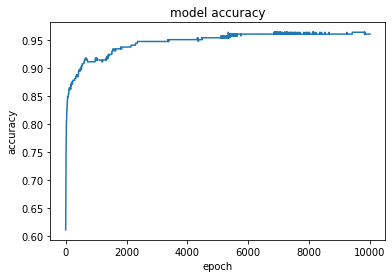

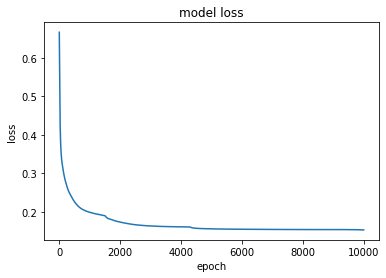

Size: 61.144453 - FPR: 0.572464 





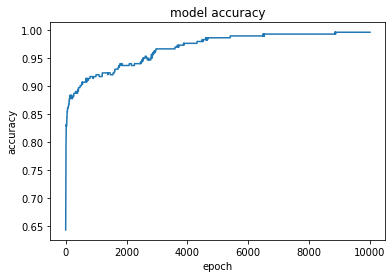

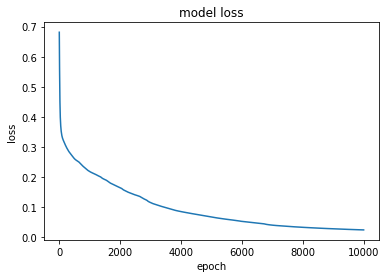

Size: 70.037188 - FPR: 0.094203 





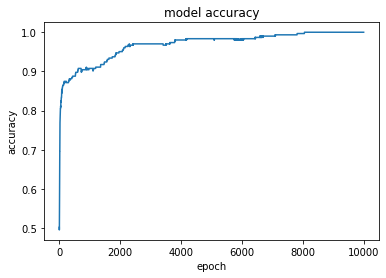

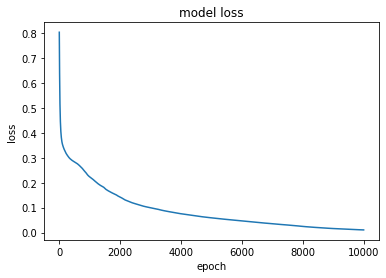

Size: 82.457031 - FPR: 0.000000 





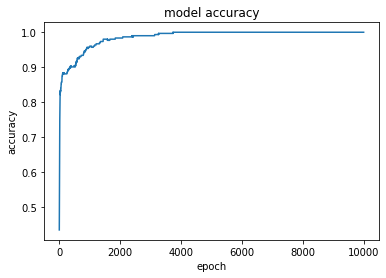

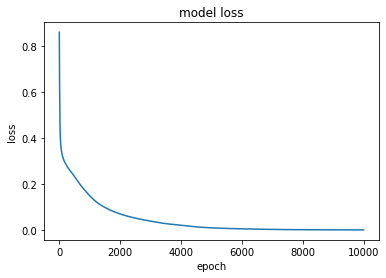

Size: 93.180391 - FPR: 0.000000 





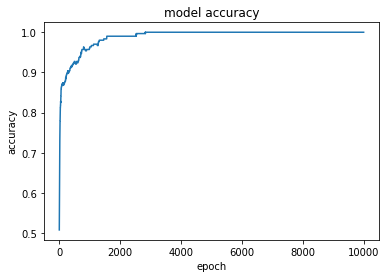

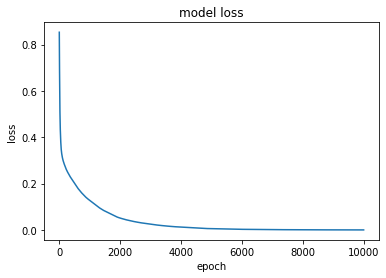

Size: 101.560234 - FPR: 0.000000 





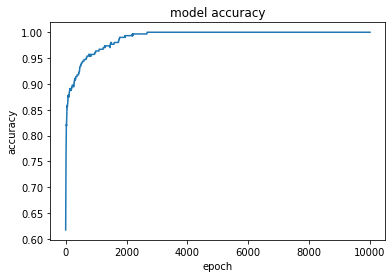

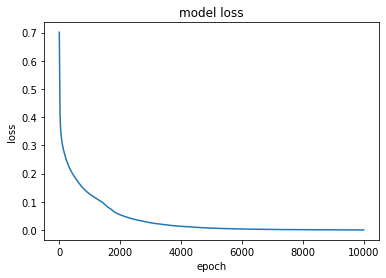

Size: 112.283594 - FPR: 0.000000 





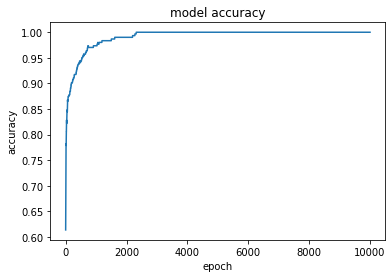

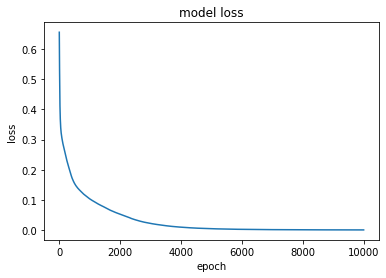

Size: 123.062188 - FPR: 0.000000 





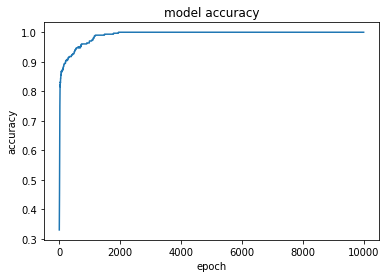

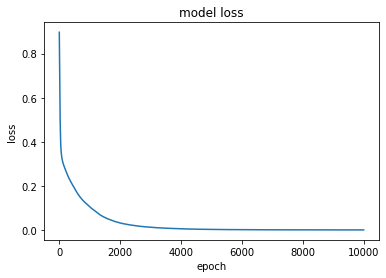

Size: 131.765547 - FPR: 0.000000 





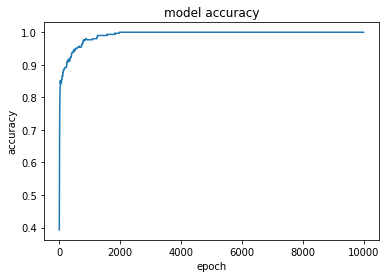

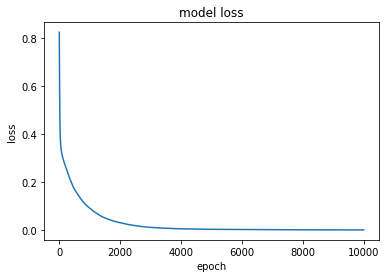

Size: 142.165391 - FPR: 0.000000 





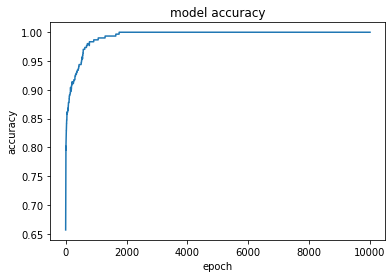

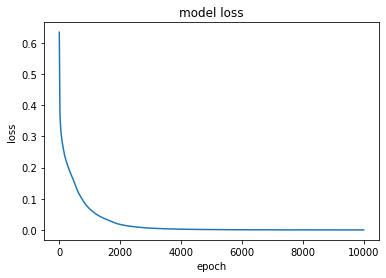

Size: 152.888750 - FPR: 0.000000 





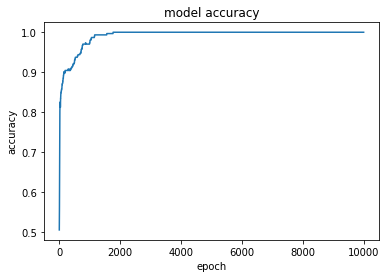

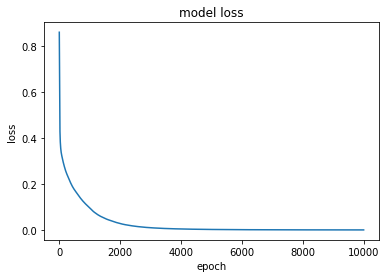

Size: 163.288594 - FPR: 0.000000 





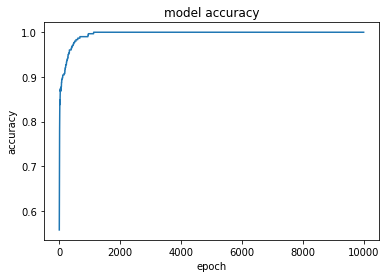

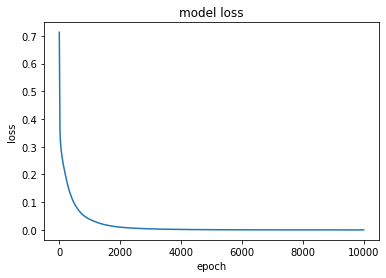

Size: 174.011953 - FPR: 0.000000 





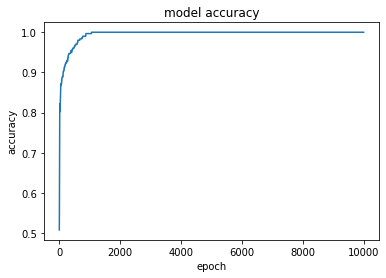

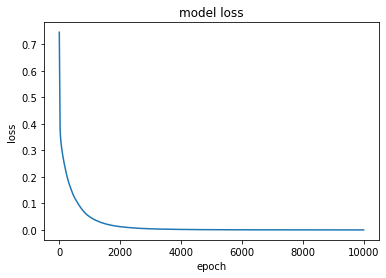

Size: 184.411797 - FPR: 0.000000 





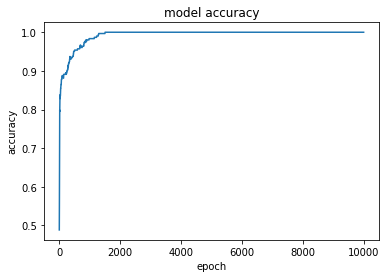

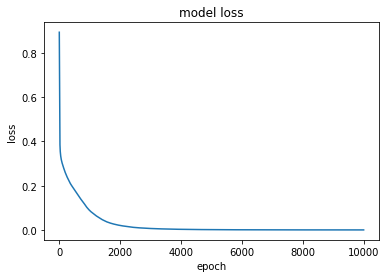

Size: 195.135156 - FPR: 0.000000 





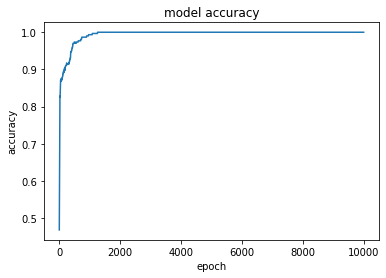

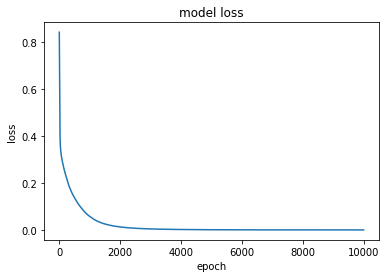

Size: 205.535000 - FPR: 0.000000 





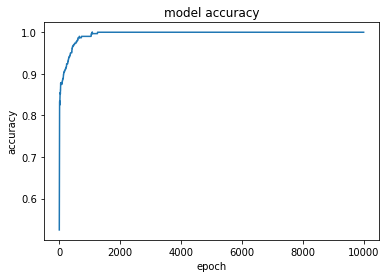

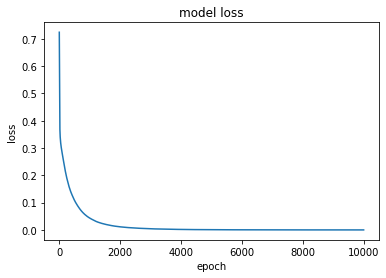

Size: 222.318359 - FPR: 0.000000 





In [24]:
get_data_points_Kraska(x_train,y_train,1,1,20,10000,fpr_values,size_values)

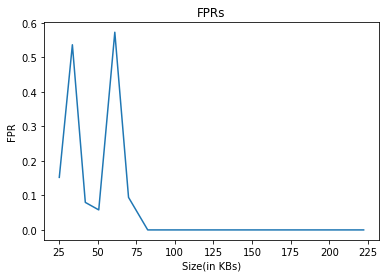

In [26]:
plt.plot(size_values,fpr_values)
plt.title('FPRs')
plt.xlabel('Size(in KBs)')
plt.ylabel('FPR')
plt.show()